# Imports

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy as sp
import scipy.stats as stats

# Importing Dataset

In [3]:
chess = pd.read_csv('./data/games.csv')

# Removing Columns with false information

#### Due to the nature of EPOCH time format being used, unfortauntely a large amount of games in this dataset have the time for "created_at" and "last_played_at" values as equal, roughly 43% of all games in this dataset allegedly did not have any time even though some games clearly show the victory status as "outoftime" or "checkmate"

In [4]:
chess.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [5]:
zero_moves = chess[chess['last_move_at']-chess['created_at'] == 0].shape[0]
print(f'There were {zero_moves} games that ended before the first move, which is \
{round(zero_moves/chess.shape[0],2)*100}% of all games')

There were 8548 games that ended before the first move, which is 43.0% of all games


#### Note how the game was created and had ended at the exact same time even though there were 13 total turns and white won on time in a 15 minute game, due to this discrepency as this is not an isolated incident, we will have to drop those 2 tables as they contain false information

In [6]:
cols_to_drop = ['id','white_id','black_id','last_move_at','created_at','moves']
chess.drop(cols_to_drop,axis=1,inplace=True)

# Preliminary Graphs

### # of Unique Openings

In [7]:
chess['opening_name'].describe()

count                    20058
unique                    1477
top       Van't Kruijs Opening
freq                       368
Name: opening_name, dtype: object

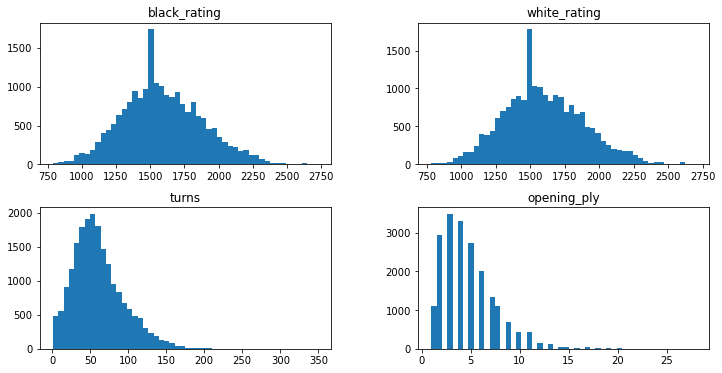

In [8]:
chess[['black_rating', 'white_rating', 'turns', 'opening_ply']].hist(figsize=(12, 6), bins=50, grid=False)
plt.show()

## Plot # of unique values for Increment and Openings

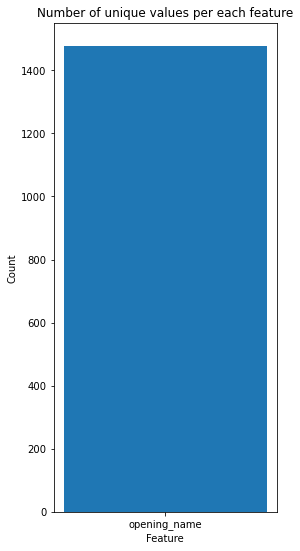

In [55]:
cat_features = np.array(['opening_name'])
count = np.array([chess[feature].unique().size for feature in cat_features])

to_sort = np.argsort(count)[::-1]
cat_features = cat_features[to_sort]
count = count[to_sort]

plt.figure(figsize=(4,9))
plt.bar(cat_features, count)
plt.title("Number of unique values per each feature")
plt.ylabel('Count')
plt.xlabel('Feature')
plt.show()

## 5 Number Summary of Player Ratings

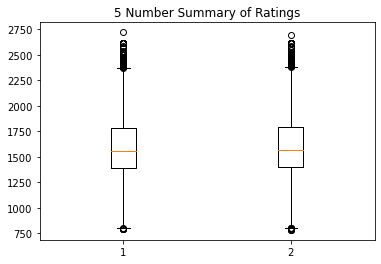

In [10]:
ratings = chess['black_rating'], chess['white_rating']

fig1, ax1 = plt.subplots()
ax1.set_title('5 Number Summary of Ratings')
ax1.boxplot(ratings)
plt.show()

In [11]:
cont_features = ['white_rating','black_rating']
chess[cont_features].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
white_rating,20058.0,1596.63,291.25,784.0,1398.0,1567.0,1793.0,2700.0
black_rating,20058.0,1588.83,291.04,789.0,1391.0,1562.0,1784.0,2723.0


## % of Winnings by Color

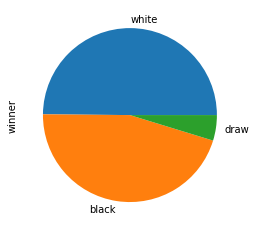

white    10001
black     9107
draw       950
Name: winner, dtype: int64

In [57]:
fig = chess['winner'].value_counts().plot.pie()
plt.show()
chess.winner.value_counts()

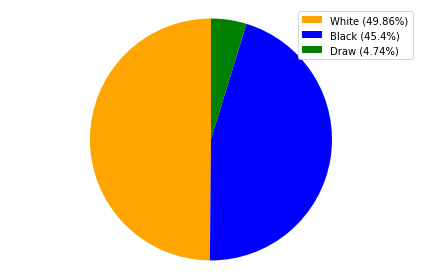

In [61]:
labels = [r'White (49.86%)', r'Black (45.4%)', r'Draw (4.74%)']
sizes = [10001, 9107, 950]
colors = ['orange', 'blue', 'green']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

## Most Popular Openings

In [13]:
opening_chess = chess.groupby(by='opening_name').winner.value_counts()
opening_chess = opening_chess.reset_index(name='wins')
opening_chess = opening_chess.sort_values(by='wins', ascending=False)

In [14]:
black_wins = opening_chess[opening_chess['winner'] == 'black']
white_wins = opening_chess[opening_chess['winner'] == 'white']

In [15]:
white_wins

,opening_name,winner,wins
2095,Scandinavian Defense: Mieses-Kotroc Variation,white,164
2190,Sicilian Defense,white,149
2113,Scotch Game,white,145
653,French Defense: Knight Variation,white,135
1451,Philidor Defense #3,white,127
...,...,...,...
930,Italian Game: Jerome Gambit,white,1
168,Blackmar-Diemer Gambit: Vienna Variation,white,1
938,Italian Game: Scotch Gambit,white,1
940,Italian Game: Scotch Gambit Declined,white,1


## How Are Most Games Won?

In [16]:
resolve = pd.DataFrame(chess.victory_status.value_counts())
resolve = resolve.reset_index()

Text(0, 0.5, 'Total Count')

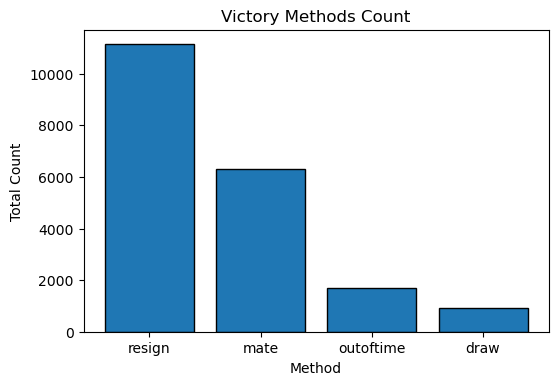

In [17]:
plt.figure(dpi=100)
plt.bar(x=resolve['index'], height=resolve.victory_status, edgecolor='black')
plt.title('Victory Methods Count')
plt.xlabel('Method')
plt.ylabel('Total Count')

## On average, how many turns does it take to win for each victory method?

Text(0, 0.5, 'Number of turns')

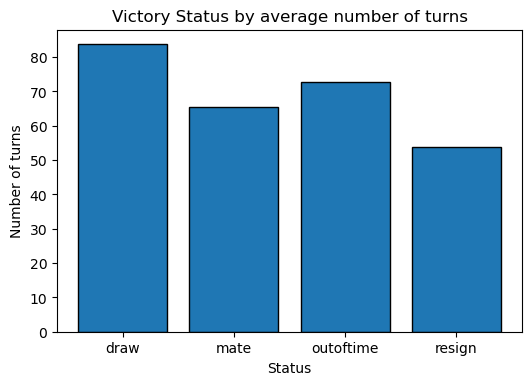

In [32]:
turn_df = chess.groupby(by='victory_status').turns.mean().reset_index()
plt.figure(dpi=100)
plt.bar(x=turn_df.victory_status, height=turn_df.turns, edgecolor='black')
plt.title('Victory Status by average number of turns')
plt.xlabel('Status')
plt.ylabel('Number of turns')

In [34]:
difference = []
for x in range(chess.shape[0]):
    temp = chess.iloc[x]
    if temp['winner'] == 'white':
        diff = temp.white_rating - temp.black_rating
        difference.append(diff)
    elif temp['winner'] == 'black':
        diff = temp.black_rating - temp.white_rating
        difference.append(diff)
    else:
        ratings = [temp.black_rating, temp.white_rating]
        diff = max(ratings) - min(ratings)
        difference.append(diff)
chess['Difference'] = np.array(difference)

Text(0, 0.5, 'Difference in rating')

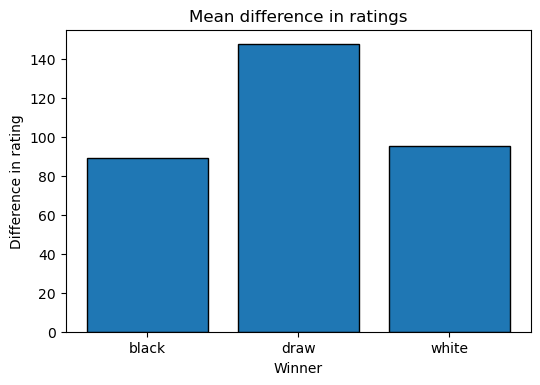

In [35]:
mean_df = chess.groupby(by='winner').Difference.mean().reset_index()
plt.figure(dpi=100)
plt.bar(x=mean_df['winner'], height=mean_df.Difference, edgecolor='black')
plt.title('Mean difference in ratings')
plt.xlabel('Winner')
plt.ylabel('Difference in rating')

In [25]:
# Probability of W given an opening
# Diff between % of wins between opening types (A-E)
# Null: Doesn't matter what the opening is (same chance of winning)
# Alt Hyp: It does matter

In [26]:
games['opening_eco']

0        D10
1        B00
2        C20
3        D02
4        C41
        ... 
20053    A80
20054    A41
20055    D00
20056    B07
20057    D00
Name: opening_eco, Length: 20058, dtype: object

In [21]:
chess['opening_group'] = chess.opening_eco.str[0]

In [22]:
chess.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,opening_group
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,D
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,B
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,C
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,D
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,5,C


In [23]:
# chess['opening_type'] = search_substring(['opening_name'])

In [24]:
search = 'Defense'
chess['opening_type'] = chess.apply(lambda row: 'black' if re.search(row['opening_name'], search) else 'white', axis=1)

In [25]:
# string.contain('defence') -> opening_type = black
# if winner = black and string.contain('defence'), win for defence
# if winner = white and string.contain('defence'), win for white

In [26]:
chess.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,opening_group,opening_type
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,D,white
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,B,white
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,C,white
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,D,white
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,5,C,white


In [27]:
chess['black_opening'] = chess['opening_name'].str.contains('Defense')

In [28]:
chess['opening_color'] = chess['black_opening'].apply(lambda row: 'black' if row == True else 'white')

In [29]:
def winner(string1, string2):
    if string1 == string2:
        return 

In [30]:
chess

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,opening_group,opening_type,black_opening,opening_color
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,D,white,True,black
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,B,white,True,black
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,C,white,False,white
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,D,white,False,white
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,5,C,white,True,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,1691,1220,A80,Dutch Defense,2,A,white,True,black
20054,True,82,mate,black,10+0,1233,1196,A41,Queen's Pawn,2,A,white,False,white
20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,3,D,white,False,white
20056,True,109,resign,white,10+0,1360,1227,B07,Pirc Defense,4,B,white,True,black


In [46]:
lst = []
#win = win_loss(chess['winner'], chess['opening_color'])
for i, j in zip(chess['winner'],chess['opening_color']):
    if i == j:
        lst.append(1)
    else:
        lst.append(0)
chess['winner'] == chess['opening_color'] 
chess['winner_for_color'] = lst
chess

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,opening_group,opening_type,black_opening,opening_color,Difference,winner_for_color
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,D,white,True,black,309,0
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,B,white,True,black,-61,1
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,C,white,False,white,-4,1
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,D,white,False,white,-15,1
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,5,C,white,True,black,54,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,1691,1220,A80,Dutch Defense,2,A,white,True,black,471,0
20054,True,82,mate,black,10+0,1233,1196,A41,Queen's Pawn,2,A,white,False,white,-37,0
20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,3,D,white,False,white,-67,1
20056,True,109,resign,white,10+0,1360,1227,B07,Pirc Defense,4,B,white,True,black,133,0


In [49]:
chess.groupby(by=['opening_group','winner_for_color']).count().iloc[:,0]

opening_group  winner_for_color
A              0                   2138
               1                   1835
B              0                   2817
               1                   2421
C              0                   4079
               1                   3579
D              0                   1413
               1                   1270
E              0                    264
               1                    242
Name: rated, dtype: int64

In [50]:
groupA = 1835 / (2138 + 1835)
groupB = 2421 / (2817 + 2421)
groupC = 3579 / (4079 + 3579)
groupD = 1270 / (1413 + 1270)
groupE = 242 / (264 + 242)

In [51]:
print(groupA, groupB, groupC, groupD, groupE)

0.461867606342814 0.46219931271477666 0.4673544006267955 0.47335072679836004 0.4782608695652174


In [ ]:
# T/F win/lose column (does winner = opening color)
# group by opening group and take win rate
# build samples of opening groups t

# looking at all win rates of opening moves INSIDE the opening groups
# hyp test between these where mean is win rate and n = # games in that opening group

# make loss column !!!!!!!!! (winner == opening_color)
# chess['win'] = 1 if is.'opening_color' == 'winner' else 0
# take vector of all Ds and As (wins = 1, loss = 0), do binom stuff

# group contains all names + win records
# test: test A through E minus D, then test D
# D vs A through E minus D
# each name + its win rate = data